## MBL Temp (GFS) - SST (NOAA)

In [1]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import datetime

root = "/home/jturner/false_low_clouds_2023/Model/Time_Lapse/"

## Time Lapse FLC

**Loading and prepping data**

Allows me to delete the large grib file in favor of two smaller pickle files

In [ ]:
date = '20230219'

In [ ]:
gfs_file = root+date+"/gfs.t00z.pgrb2.0p25.f000"

gfs_ds = xr.open_dataset(gfs_file, engine="cfgrib",backend_kwargs={'filter_by_keys': {'typeOfLevel':'isobaricInhPa'}})

Mean and max for the GFS to the marine boundary layer:

In [ ]:
min_press = 850 #mb
max_press = 1000 #mb

gfs_ds = gfs_ds.sel(isobaricInhPa=slice(max_press,min_press))

gfs_ds_mean = gfs_ds.mean(dim='isobaricInhPa')
gfs_ds_mean = gfs_ds_mean.squeeze()
gfs_ds_mean = gfs_ds_mean.reindex(latitude=gfs_ds_mean.latitude[::-1])

gfs_ds_max = gfs_ds.max(dim='isobaricInhPa')
gfs_ds_max = gfs_ds_max.squeeze()
gfs_ds_max = gfs_ds_max.reindex(latitude=gfs_ds_max.latitude[::-1])

Creating and saving the T-diff:

In [ ]:
t = gfs_ds_mean.t

t.to_netcdf(root+date+'/t_'+date+'.nc')

Saving the moisture:
* currently using max in layer

In [ ]:
q = gfs_ds_max.q

q.to_netcdf(root+date+'/q_'+date+'.nc')

**Loading pre-made data**

In [2]:
date = '20230219'

sst_file = root+date+"/oisst-avhrr-v02r01."+date+".nc"

sst_ds = xr.open_dataset(sst_file)
sst_ds =  sst_ds.squeeze()
sst_ds.sst.values = sst_ds.sst.values+273.15

In [3]:
t = xr.open_dataset(root+date+'/t_'+date+'.nc')
q = xr.open_dataset(root+date+'/q_'+date+'.nc')

In [4]:
min_lon = -102 + 360
min_lat = 23
max_lon = -81 + 360
max_lat = 5

In [5]:
sst_ds = sst_ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon))
t = t.sel(latitude=slice(max_lat,min_lat), longitude=slice(min_lon,max_lon))
q = q.sel(latitude=slice(max_lat,min_lat), longitude=slice(min_lon,max_lon))

In [6]:
begin = sst_ds.sst.shape[0]
end = sst_ds.sst.shape[1]

dims = t.t[0:begin,0:end]

diff = t.t[0:begin,0:end].values - sst_ds.sst[:,:].values

In [7]:
bottom_lim = -4

diff_np = np.asarray(diff).copy()
under_zero = diff_np < bottom_lim
diff_np[under_zero] = bottom_lim

In [8]:
top_T = 4

diff_norm = diff_np/(top_T - bottom_lim)

In [9]:
top_q = 0.016
bottom_q = 0.000
q_norm = (q.q[0:begin,0:end].values)/(top_q - bottom_q)
q_norm_av = (q.q[0:begin,0:end].values)/(top_q - bottom_q)

In [10]:
flc_index = diff_norm*q_norm

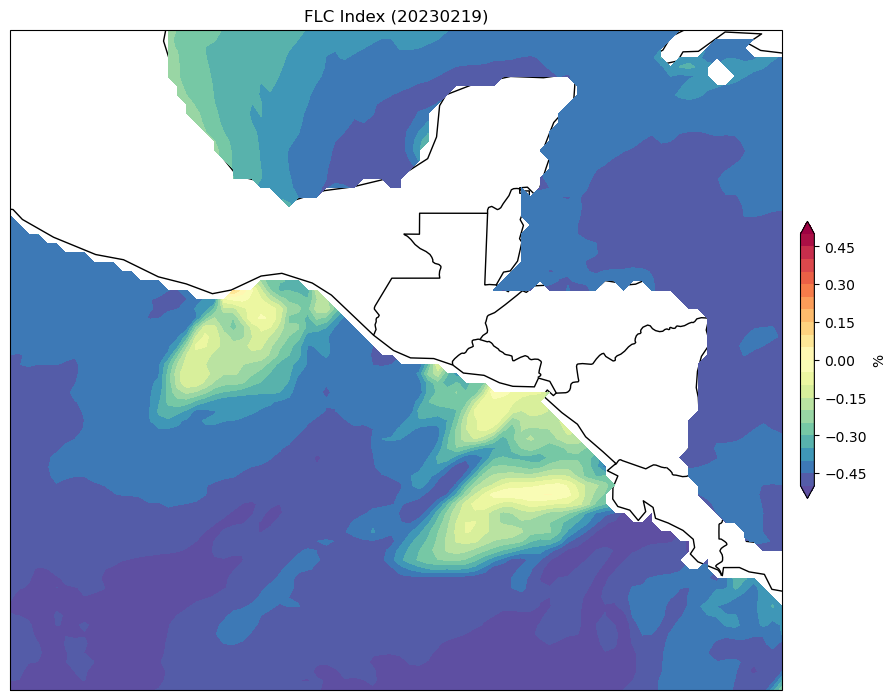

In [11]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Spectral_r
levels = np.linspace(-0.5, 0.5, 21)

ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS)
c=ax.contourf(dims.longitude, dims.latitude, flc_index, cmap=cmap, levels=levels, extend='both')
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('FLC Index ('+date+')')
clb.set_label('%')

#plt.savefig('/Users/jesseturner/Downloads/flc_index_'+date+'.png', dpi=300)

**Bulk loading pre-made data**

In [12]:
def FLC_warn_xarray(date):
    
    sst_file = root+date+"/oisst-avhrr-v02r01."+date+".nc"
    sst_ds = xr.open_dataset(sst_file)
    sst_ds =  sst_ds.squeeze()
    sst_ds.sst.values = sst_ds.sst.values+273.15
    
    t = xr.open_dataset(root+date+'/t_'+date+'.nc')
    q = xr.open_dataset(root+date+'/q_'+date+'.nc')
    
#---Northeast US
    min_lon = -83 + 360
    min_lat = 50
    max_lon = -51 + 360
    max_lat = 26
    
#---Central America
#     min_lon = -102 + 360
#     min_lat = 23
#     max_lon = -81 + 360
#     max_lat = 5

    sst_ds = sst_ds.sel(lat=slice(max_lat,min_lat), lon=slice(min_lon,max_lon))
    t = t.sel(latitude=slice(max_lat,min_lat), longitude=slice(min_lon,max_lon))
    q = q.sel(latitude=slice(max_lat,min_lat), longitude=slice(min_lon,max_lon))

    begin = sst_ds.sst.shape[0]
    end = sst_ds.sst.shape[1]

    dims = t.t[0:begin,0:end]

    diff = t.t[0:begin,0:end].values - sst_ds.sst[:,:].values

    bottom_lim = -4

    diff_np = np.asarray(diff).copy()
    under_zero = diff_np < bottom_lim
    diff_np[under_zero] = bottom_lim

    top_T = 4

    diff_norm = diff_np/(top_T - bottom_lim)

    top_q = 0.016
    bottom_q = 0.000
    q_norm = (q.q[0:begin,0:end].values)/(top_q - bottom_q)
    q_norm_av = (q.q[0:begin,0:end].values)/(top_q - bottom_q)

    flc_index = diff_norm*q_norm

    #---Building the xarray dataset
    
    row_meshgrid, col_meshgrid = np.meshgrid(dims.latitude, dims.longitude, indexing='ij')

    ds = xr.Dataset(
        data_vars=dict(
            flc_index=(["x","y"], flc_index)
        ),
        coords=dict(
            latitude=(["x","y"], row_meshgrid),
            longitude=(["x","y"], col_meshgrid),
        ),
        attrs=dict(description="FLC index in the US Atlantic region"),
    )
    
    ds = ds.expand_dims(dim={"time": 1})
    
    return ds

Add the datetimes in here: 

In [13]:
FLC_3d_xarray = [FLC_warn_xarray('20230322'), FLC_warn_xarray('20230323'), 
                FLC_warn_xarray('20230324'), FLC_warn_xarray('20230325'),
                FLC_warn_xarray('20230326'), FLC_warn_xarray('20230327'),
                FLC_warn_xarray('20230328'), FLC_warn_xarray('20230329'),
                FLC_warn_xarray('20230330'), FLC_warn_xarray('20230331'),
                FLC_warn_xarray('20230401'), FLC_warn_xarray('20230402'),
                FLC_warn_xarray('20230403'), FLC_warn_xarray('20230404'),
                FLC_warn_xarray('20230405'), FLC_warn_xarray('20230406'),
                FLC_warn_xarray('20230407'), FLC_warn_xarray('20230408'),
                FLC_warn_xarray('20230409'), FLC_warn_xarray('20230410'),
                FLC_warn_xarray('20230411'), FLC_warn_xarray('20230412'),]

dates = [datetime.datetime(2023, 3, 22), datetime.datetime(2023, 3, 23), 
        datetime.datetime(2023, 3, 24), datetime.datetime(2023, 3, 25),
        datetime.datetime(2023, 3, 26), datetime.datetime(2023, 3, 27),
        datetime.datetime(2023, 3, 28), datetime.datetime(2023, 3, 29),
        datetime.datetime(2023, 3, 30), datetime.datetime(2023, 3, 31),
        datetime.datetime(2023, 4, 1), datetime.datetime(2023, 4, 2),
        datetime.datetime(2023, 4, 3), datetime.datetime(2023, 4, 4),
        datetime.datetime(2023, 4, 5), datetime.datetime(2023, 4, 6),
        datetime.datetime(2023, 4, 7), datetime.datetime(2023, 4, 8),
        datetime.datetime(2023, 4, 9), datetime.datetime(2023, 4, 10),
        datetime.datetime(2023, 4, 11), datetime.datetime(2023, 4, 12),]

In [14]:
da_concat = xr.concat(FLC_3d_xarray, pd.Index(dates, name='time'))

In [15]:
tot = da_concat.sum(dim='time')

In [16]:
flc_above = tot.flc_index.where(tot.flc_index > 0.1)

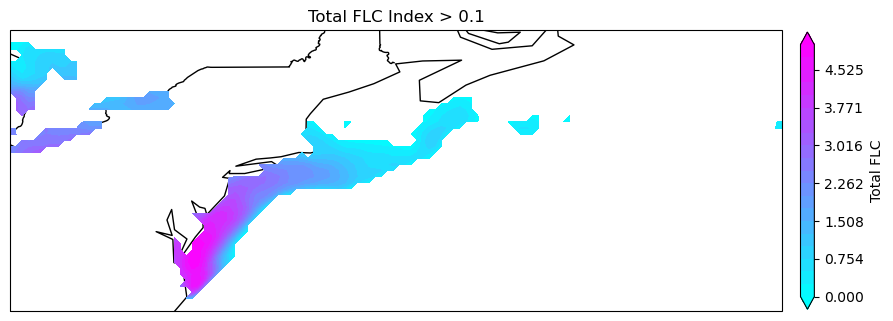

In [17]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.cool
levels = np.linspace(0, np.amax(flc_above), 21)

ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS)
c=ax.contourf(flc_above.longitude[0,:], flc_above.latitude[:,0], flc_above, cmap=cmap, levels=levels, extend='both')
clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Total FLC Index > 0.1')
clb.set_label('Total FLC')

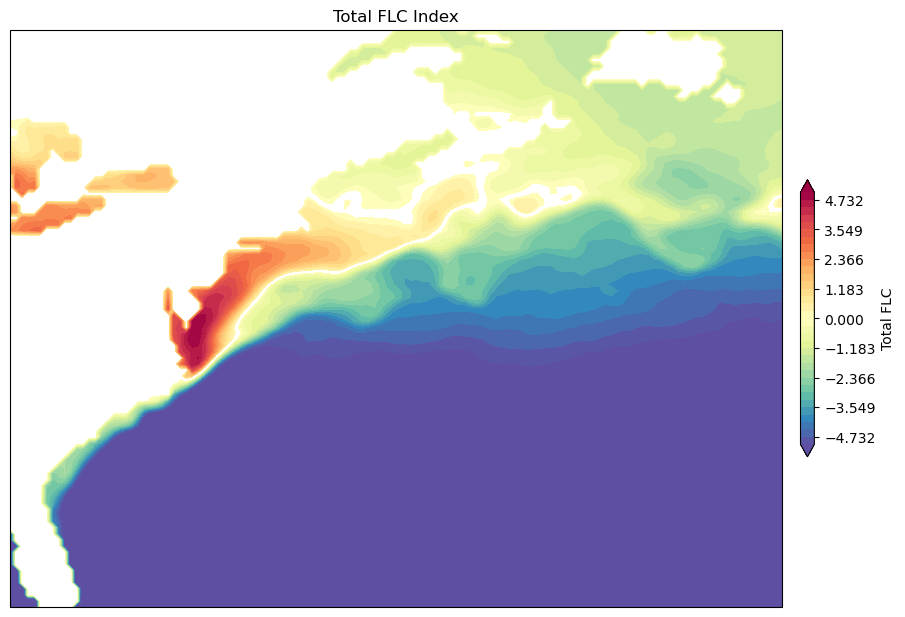

In [18]:
projection=ccrs.PlateCarree()
fig,ax=plt.subplots(1, figsize=(12,12),subplot_kw={'projection': projection})
cmap = plt.cm.Spectral_r
levels = np.linspace(-np.amax(tot.flc_index), np.amax(tot.flc_index), 35)
#---since Central America values are negative
#levels = np.linspace(-12, 12, 71)

ax.coastlines(resolution='110m')
ax.add_feature(cfeature.BORDERS)
c=ax.contourf(tot.longitude[0,:], tot.latitude[:,0], tot.flc_index, cmap=cmap, levels=levels, extend='both')

#---hacky way of adding white = 0
white_levels = [-.1,.1]
c_white=ax.contourf(tot.longitude[0,:], tot.latitude[:,0], tot.flc_index, levels=white_levels, colors='w')

clb=plt.colorbar(c, shrink=0.3, pad=0.02, ax=ax)
ax.set_title('Total FLC Index')
clb.set_label('Total FLC')

#plt.savefig('/Users/jturner/Downloads/total_flc_index_CentralAmerica.png', dpi=300)

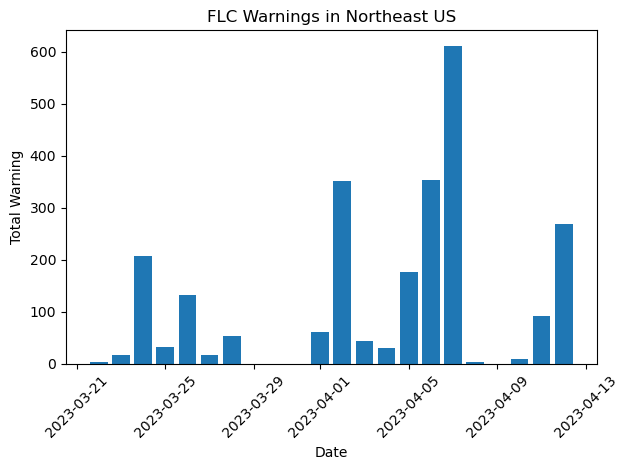

In [19]:
flc_above = []
da_tot_area = []
flc_above = da_concat.flc_index.where(da_concat.flc_index > 0.1)
da_tot_area = flc_above.sum(dim='x').sum(dim='y')

plt.bar(da_tot_area['time'], da_tot_area)

# add labels and title
plt.xlabel('Date')
plt.ylabel('Total Warning')
plt.title('FLC Warnings in Northeast US')
plt.xticks(rotation=45)

plt.tight_layout()
#plt.savefig('/Users/jturner/Downloads/total_flc_index_bar_NortheastUS.png', dpi=300)